In this notebook we present models that can be used for predicting stock market sentiments. We Approach the problem first by using an assortment of machine learning based approaches that include
- Random Forest
- Gradient Boosting
- AdaBoost
- LightGBM
- XGBoost
- Decision Tree
- Support Vector Machine
- Naive Bayes
- Multilayer Perceptron

We Find that the aformentioned approaches unpromising and so switch to a deep learning based approach where a Large Language Model (LLM), RoBERTa, in this case, which has been pretrained is finetuned to our task of sentiment classification, It proves to be much better than the machine learning based approaches and achieves an accuracy of 86.32% after just 5 epochs of fine tuning.

## Setup

In [1]:
%%capture
!pip install transformers
!pip install accelerate
# uncomment below cell to train on TPU's
#!pip install cloud-tpu-client==0.10 torch==1.9.0 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl
!pip install git+https://github.com/huggingface/accelerate
!pip install ml_collections
!pip install datasets
!pip install ydata-profiling
!pip install emoji
!pip install datasets
!pip install evaluate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import ml_collections
import datasets
import torch
import transformers
from accelerate import Accelerator, DistributedType
from datasets import Dataset, DatasetDict
from evaluate import load as load_metric
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup,
    set_seed,
)

import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import emoji
from wordcloud import WordCloud, STOPWORDS
import re,string, nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.stem.snowball import SnowballStemmer

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings(action="ignore")

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
# Setting up the model hyperparameters

def model_config():
    cfg_dictionary = {
        "data_path": "/content/data.csv",
        "model_path": "BERT.h5",
        "model_type": "transformer",

        "test_size": 0.1,
        "validation_size":0.2,
        "train_batch_size": 32,
        "eval_batch_size": 32,

        "epochs": 5,
        "adam_epsilon": 1e-8,
        "lr": 3e-5,
        "num_warmup_steps": 10,

        "max_length": 128,
        "random_seed": 42,
        "num_labels": 3,
        "model_checkpoint":"roberta-base",
    }
    cfg = ml_collections.FrozenConfigDict(cfg_dictionary)

    return cfg
cfg = model_config()

## Preprocessing

Almost all text we find is unsanitised and contains many characters that can trip up out model, we perform a regime of cleaning steps that remove URL's, Emoji's, Special Characters that appear very infrequenty in the english language. When it comes to applying non deep learning models, such as XGBoost, Decision Trees etc, we perfom stemming and lemmatization that further simplifies the word in the text. For, Large Language Models (LLM's) these preporcessing steps seem unnessary, and so we skip them.

In [5]:
def clean_text(df,field):
    df[field] = df[field].str.replace(r"http\S+"," ")
    df[field] = df[field].str.replace(r"http"," ")
    df[field] = df[field].str.replace(r"@","at")
    df[field] = df[field].str.replace("#[A-Za-z0-9_]+", ' ')
    df[field] = df[field].str.replace(r"[^A-Za-z(),!?@\'\"_\n]"," ")
    df[field] = df[field].str.lower()
    return df

lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
STOPWORDS.update(['rt', 'mkr', 'didn', 'bc', 'n', 'm','im', 'll', 'y', 've',
                      'u', 'ur', 'don','p', 't', 's', 'aren', 'kp', 'o', 'kat',
                      'de', 're', 'amp', 'will'])

def preprocess_text(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would",text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub('[^a-zA-Z]',' ',text)
    text = re.sub(emoji.get_emoji_regexp(),"",text)
    text = re.sub(r'[^\x00-\x7f]','',text)
    text = " ".join([stemmer.stem(word) for word in text.split()])
    text = [lemmatizer.lemmatize(word) for word in text.split() if not word in set(STOPWORDS)]
    text = ' '.join(text)
    return text


In [6]:
def preprocess_csv(csv_file: str) -> pd.DataFrame:
    df = pd.read_csv(csv_file)

    labelencoder = LabelEncoder()
    df["label_enc"] = labelencoder.fit_transform(df["Sentiment"])
    df.rename(columns={"label": "label_desc"}, inplace=True)
    df.rename(columns={"label_enc": "labels"}, inplace=True)
    df.drop_duplicates(subset=['Sentence'],keep='first',inplace=True)

    cleaned_df = clean_text(df, "Sentence")

    if cfg.model_type is not "transformer":
        cleaned_df["Sentence"] = cleaned_df["Sentence"].apply(preprocess_text)
    return cleaned_df

## EDA

Pandas Profiling is an amazing library that helps you extract important information from dataframes in one shot. No need to call `df.head()`. `df.describe()`, `df.info()` multiple times to perform EDA, Pandas Profiling takes care of that and much more for you.

In [7]:
df = preprocess_csv(cfg.data_path)

In [8]:

profile = ProfileReport(df, title="Financial Sentiment Analysis")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## ML Based Approach

In [9]:
X_train, X_test, y_train, y_test = train_test_split(np.array(df["Sentence"]),np.array(df["labels"]), test_size=0.25, random_state=42)

In [10]:
tfidf = TfidfVectorizer(use_idf=True, tokenizer=word_tokenize,min_df=0.00002,max_df=0.70)

X_train_tf = tfidf.fit_transform(X_train.astype('U'))
X_test_tf = tfidf.transform(X_test.astype('U'))

print(f"TF_IDF Model: Train features shape:{X_train_tf.shape} and Test features shape:{X_test_tf.shape}")

TF_IDF Model: Train features shape:(3991, 11090) and Test features shape:(1331, 11090)


In [28]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)
ada = AdaBoostClassifier(random_state=42)
lgb = LGBMClassifier(random_state=42)
xgb = XGBClassifier(eval_metric="mlogloss",random_state=42)
dt = DecisionTreeClassifier(random_state=42)
svc = SVC(random_state=42)
nb = MultinomialNB()
mlp = MLPClassifier(random_state=42)

clfs = {
    "Random Forest": rf,
    "Gradient Boosting":gb,
    "AdaBoost": ada,
    "LightGBM": lgb,
    "XGBoost": xgb,
    "Decision Tree":dt,
    "Support Vector Machine":svc,
    "Naive Bayes": nb,
    "Multilayer Perceptron":mlp
}

def fit_model(clf,x_train,y_train,x_test, y_test):
    clf.fit(x_train,y_train)
    y_pred = clf.predict(x_test)
    accuracy = accuracy_score(y_pred, y_test)
    return accuracy

accuracies = []

for name,clf in tqdm(clfs.items()):
    curr_acc = fit_model(clf,X_train_tf,y_train,X_test_tf,y_test)
    accuracies.append(curr_acc)

  0%|          | 0/9 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13535
[LightGBM] [Info] Number of data points in the train set: 3991, number of used features: 494
[LightGBM] [Info] Start training from score -2.235013
[LightGBM] [Info] Start training from score -0.604717
[LightGBM] [Info] Start training from score -1.059064


In [29]:
models_df = pd.DataFrame({"Models":clfs.keys(),"Accuracy Scores":accuracies}).sort_values('Accuracy Scores',ascending=False)
models_df

,Models,Accuracy Scores
4,XGBoost,0.759579
6,Support Vector Machine,0.750563
8,Multilayer Perceptron,0.749812
3,LightGBM,0.746807
1,Gradient Boosting,0.737791
0,Random Forest,0.716003
2,AdaBoost,0.711495
7,Naive Bayes,0.684448
5,Decision Tree,0.662660


## Transformers to the rescue
It looks like the previous results are unpromising. Let's bring out the Big Guns. HuggingFace acceleate is another amazing library that manages training really well, it doesn't matter which backend you're using (CPU/GPU/TPU). the accelerate library will let you train your model without any code changes. Using TPU's to train your model is as easy as install `torch-xla` and running `notebook_launcher(training_function)`

In [17]:
def create_dataset(dataframe):
    training_df, test_df = train_test_split(
        dataframe,
        test_size=cfg.test_size,
        random_state=cfg.random_seed,
        stratify=dataframe.labels.values,
    )
    train_df, val_df = train_test_split(
        training_df,
        test_size=cfg.validation_size,
        random_state=cfg.random_seed,
        stratify=training_df.labels.values,
    )

    dataset = {
        "train": Dataset.from_pandas(train_df),
        "validation": Dataset.from_pandas(val_df),
        "test": Dataset.from_pandas(test_df),
    }

    dataset = DatasetDict(dataset)

    return dataset

In [18]:
def tokenize_dataset():
    dataset = create_dataset(preprocess_csv(cfg.data_path))
    tokenizer = AutoTokenizer.from_pretrained(cfg.model_checkpoint,use_fast=True)

    def tokenize_function(sample):
        outputs = tokenizer(
            sample["Sentence"],
            truncation=True,
            padding="max_length",
            max_length=cfg.max_length,
        )
        return outputs

    tokenized_datasets = dataset.map(
        tokenize_function, batched=True, remove_columns=["Sentence","Sentiment","__index_level_0__"]
    )
    tokenized_datasets.set_format("torch")

    return tokenized_datasets

In [19]:
def create_dataloaders():
    tokenized_datasets = tokenize_dataset()
    train_dataloader = DataLoader(
        tokenized_datasets["train"], shuffle=True, batch_size=cfg.train_batch_size
    )
    eval_dataloader = DataLoader(
        tokenized_datasets["validation"], shuffle=False, batch_size=cfg.eval_batch_size
    )
    return train_dataloader, eval_dataloader

In [20]:
def training_function():
    accelerator = Accelerator()

    set_seed(cfg.random_seed)
    tokenized_datasets = tokenize_dataset()
    accuracy = load_metric("accuracy")

    if accelerator.is_main_process:
        datasets.utils.logging.set_verbosity_warning()
        transformers.utils.logging.set_verbosity_info()
    else:
        datasets.utils.logging.set_verbosity_error()
        transformers.utils.logging.set_verbosity_error()

    train_dataloader, eval_dataloader = create_dataloaders()
    model = AutoModelForSequenceClassification.from_pretrained(
        cfg.model_checkpoint, num_labels=cfg.num_labels
    )
    optimizer = torch.optim.AdamW(
        params=model.parameters(), eps=cfg.adam_epsilon, lr=cfg.lr
    )
    model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
        model, optimizer, train_dataloader, eval_dataloader
    )
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,
        num_warmup_steps=cfg.num_warmup_steps,
        num_training_steps=len(train_dataloader) * cfg.epochs,
    )
    progress_bar = tqdm(
        range(cfg.epochs * len(train_dataloader)),
        disable=not accelerator.is_main_process,
    )

    # Model Training
    for epoch in range(cfg.epochs):
        model.train()
        for step, batch in enumerate(train_dataloader):
            outputs = model(**batch)
            loss = outputs.loss
            accelerator.backward(loss)

            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            progress_bar.update(1)

        model.eval()
        all_predictions = []
        all_labels = []

        for step, batch in enumerate(eval_dataloader):
            with torch.no_grad():
                outputs = model(**batch)
            predictions = outputs.logits.argmax(dim=-1)

            # gather predictions and labels from the 8 TPUs
            all_predictions.append(accelerator.gather(predictions))
            all_labels.append(accelerator.gather(batch["labels"]))

        # Concatenate all predictions and labels.
        all_predictions = torch.cat(all_predictions)[
            : len(tokenized_datasets["validation"])
        ]
        all_labels = torch.cat(all_labels)[: len(tokenized_datasets["validation"])]

        eval_accuracy = accuracy.compute(
            predictions=all_predictions, references=all_labels
        )

        # Use accelerator.print to print only on the main process.
        accelerator.print(f"epoch {epoch}:", eval_accuracy)

In [21]:
from accelerate import notebook_launcher
notebook_launcher(training_function)

Launching training on one GPU.


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/3831 [00:00<?, ? examples/s]

Map:   0%|          | 0/958 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/vocab.json
loading file

Map:   0%|          | 0/3831 [00:00<?, ? examples/s]

Map:   0%|          | 0/958 [00:00<?, ? examples/s]

Map:   0%|          | 0/533 [00:00<?, ? examples/s]

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.44.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--roberta-base/snapshots/e2da8e2f811d1448a5b465c236feacd80ffbac7b/model.safetensors
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkp

epoch 0: {'accuracy': 0.8423799582463466}


 40%|████      | 241/600 [02:45<14:43,  2.46s/it]

epoch 1: {'accuracy': 0.8653444676409185}


 60%|██████    | 361/600 [04:11<09:51,  2.48s/it]

epoch 2: {'accuracy': 0.8768267223382046}


 80%|████████  | 481/600 [05:36<04:57,  2.50s/it]

epoch 3: {'accuracy': 0.8674321503131524}


100%|██████████| 600/600 [07:02<00:00,  1.42it/s]

epoch 4: {'accuracy': 0.872651356993737}


## Conclusion

In [23]:
RoBERTa = {'Models': 'RoBERTa', 'Accuracy Scores': 0.8262}
models_df = pd.concat([models_df, pd.DataFrame([RoBERTa])], ignore_index=True)

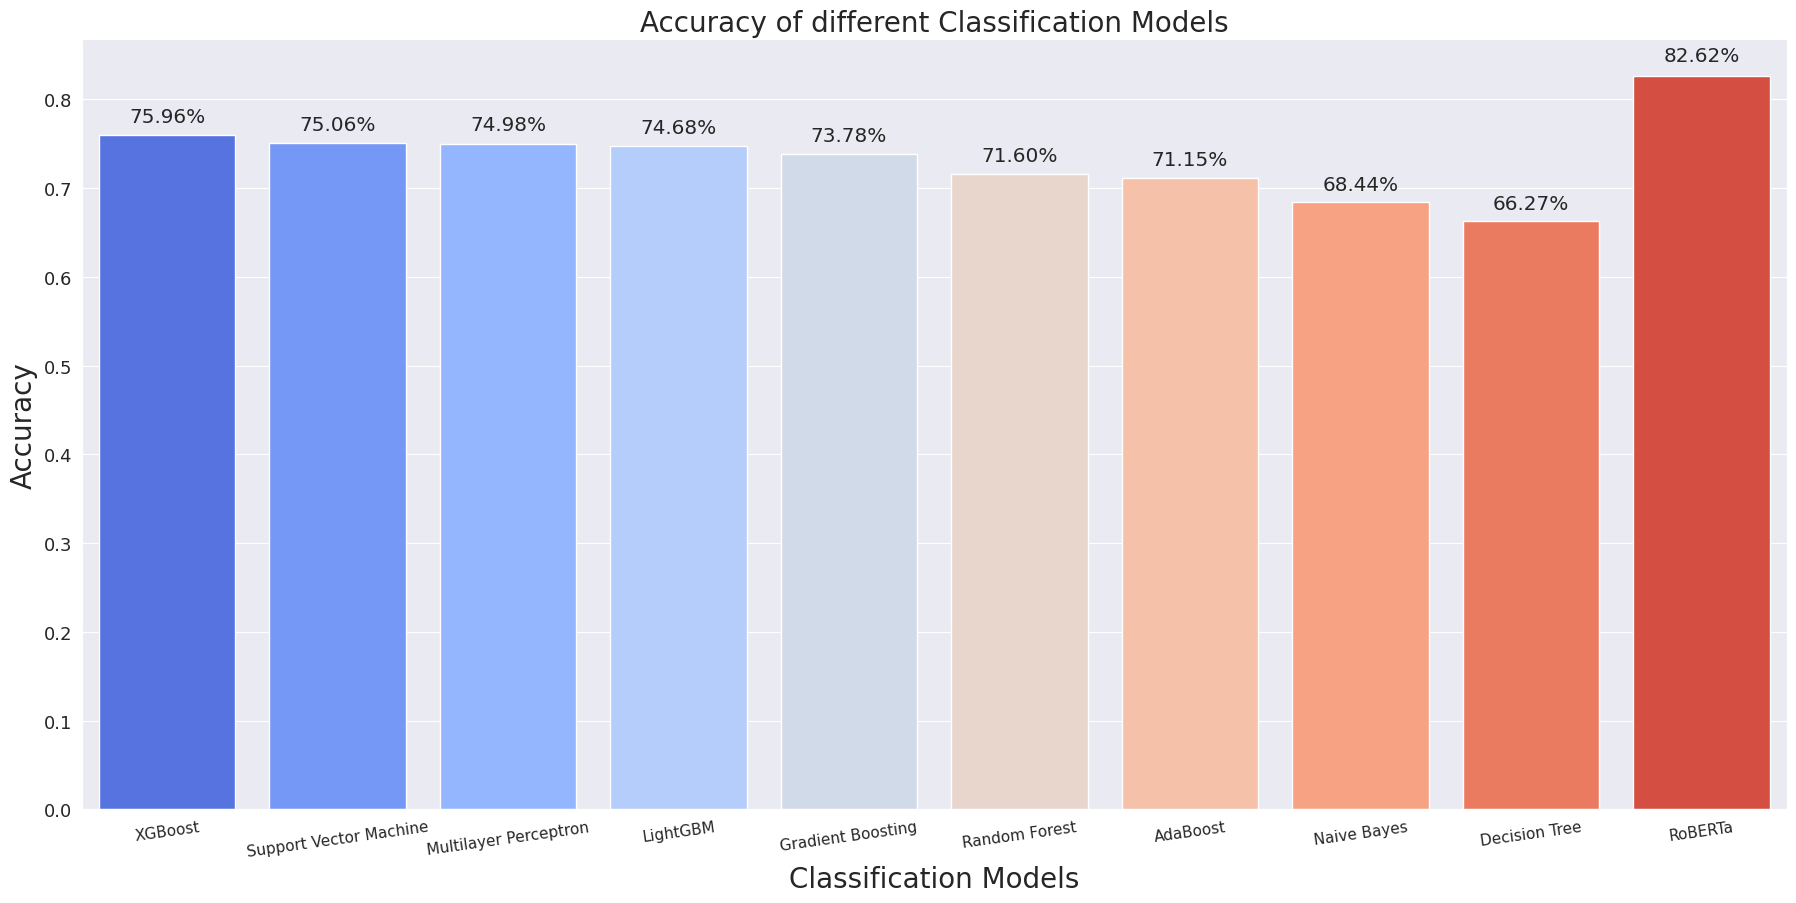

In [24]:
plt.rcParams['figure.figsize']=22,10
sns.set_style("darkgrid")
ax = sns.barplot(x=models_df["Models"], y=models_df["Accuracy Scores"], palette = "coolwarm", saturation =1.5)
plt.xlabel("Classification Models", fontsize = 20 )
plt.ylabel("Accuracy", fontsize = 20)
plt.title("Accuracy of different Classification Models", fontsize = 20)
plt.xticks(fontsize = 11, horizontalalignment = 'center', rotation = 8)
plt.yticks(fontsize = 13)
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.annotate(f'{height:.2%}', (x + width/2, y + height*1.02), ha='center', fontsize = 'x-large')
plt.show()